## PCANet: Learning diffusivity (m) to solution (u) map for the Poisson problem

In [2]:
import sys
import os

import numpy as np # load numpy before torch
import torch
from torch.nn.utils import parameters_to_vector


src_path = "../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import field_plot 
from plot_loss import plot_loss 
from plot_svd import plot_s_vec_values 

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessor

sys.path.append(src_path + 'nn/pcanet/')
sys.path.append(src_path + 'nn/mlp/') 
sys.path.append(src_path + 'uq/')
from torch_pcanet import PCANet
import uq_pcanet as uq
import uq_evaluation as uq_eval

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
data_folder = '../../../autodl-tmp/data/'
results_dir = data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [4]:
num_train = 3500
num_test = 1000

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 1 # scalar field
num_inp_red_dim = 100 # number of reduced dimensions for the input data
num_out_red_dim = 100 # number of reduced dimensions for the output data
out_coordinate_dimension = 2 # domain for output function is 2D

# training hyperparameters
batch_size = 20
epochs = 1000
lr = 1.0e-3
act_fn = torch.nn.GELU()

data_prefix = 'Poisson'

data = DataProcessor(data_folder + data_prefix + '_samples_.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components, num_inp_red_dim, num_out_red_dim)
train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

print('X_train_svd_projector:',data.X_train_svd_projector.shape)
print('Y_train_svd_projector:',data.Y_train_svd_projector.shape)

X_train: (3500, 100)
Y_train: (3500, 100)
X_test: (1000, 100)
Y_test: (1000, 100)
X_trunk: (2601, 2)
X_train_svd_projector: (100, 2601)
Y_train_svd_projector: (100, 2601)


In [5]:
num_test_shift = 400
# Shifting data sets
data_type=[['no-ood',0.005,0.2,1,0],['ood-1',0.0005,0.2,1,0],['ood-2',0.001,0.2,1,0],\
           ['ood-3',0.01,0.2,1,0],['ood-4',0.05,0.2,1,0],['ood-5',0.1,0.2,1,0], \
            ['ood-6',0.5,0.2,1,0]]
data_shifting = []
data_shifting_data = []
for datatype in data_type:
    data_shifting.append(DataProcessor(data_folder + data_prefix + f'_samples_{datatype[0]}.npz', 100, 400, num_inp_fn_points, num_out_fn_points, num_Y_components,num_inp_red_dim, num_out_red_dim))
    data_shifting_data.append({'X_train': data_shifting[-1].X_test, 'X_trunk': data_shifting[-1].X_trunk, 'Y_train': data_shifting[-1].Y_test})

### Plot singular values

j = 0, i = 0, index = 100, index_val = 0.032590066211883206
j = 0, i = 1, index = 100, index_val = 0.0033409165710523744
j = 1, i = 0, index = 35, index_val = 0.1006803895025745
j = 1, i = 1, index = 10, index_val = 0.10902619155367585
j = 2, i = 0, index = 289, index_val = 0.01000805121239042
j = 2, i = 1, index = 50, index_val = 0.009894120146498975


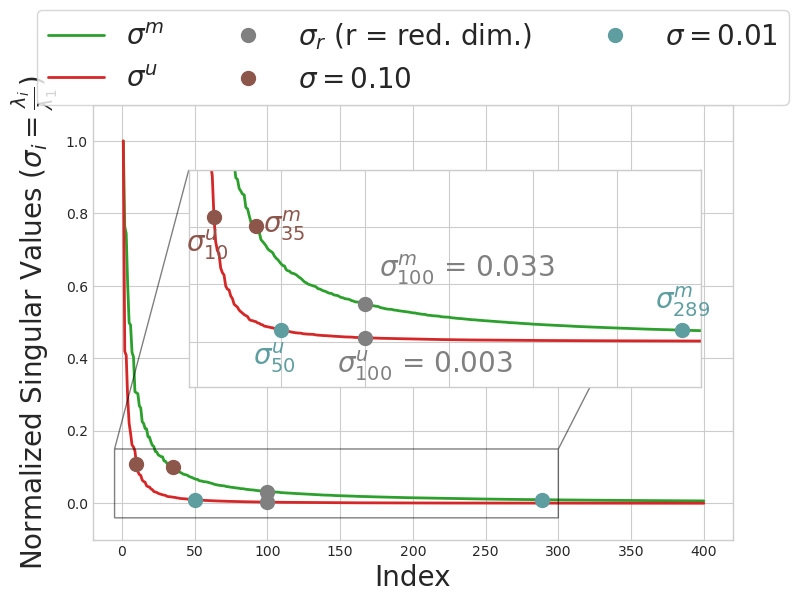

In [ ]:
plot_annot_xy = [0.15, 0.35, 0.8, 0.5]
plot_annot_xy_region = [-5, 300, -0.04, 0.15]
xy_text_vec = []
xy_text_vec.append([(10, 20), (-20, -25)])
xy_text_vec.append([(5, -5), (-20, -25)])
xy_text_vec.append([(-20, 15), (-20, -25)])
l_style_vec = ['-', '-']
plot_s_vec_values([data.X_train_s_values, data.Y_train_s_values], [num_inp_red_dim, num_out_red_dim], \
                    ['m', 'u'], \
                    l_style_vec, \
                    xy_text_vec, \
                    plot_annot_xy, \
                    plot_annot_xy_region, \
                    results_dir + data_prefix + '_svd_analysis_m_u')

## Create model and train the network

In [6]:
num_layers = 4
num_neurons = 250
model_save_path = results_dir + 'PCANet/'
model_save_file = model_save_path + 'model.pkl'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = PCANet(num_layers, num_neurons, act_fn, \
               num_inp_red_dim, num_out_red_dim, \
               save_file = model_save_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Using device: cuda
Number of trainable parameters: 175850


In [ ]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_inp_fn_points': num_inp_fn_points, \
                    'num_out_fn_points': num_out_fn_points, \
                    'num_Y_components': num_Y_components, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'num_inp_red_dim': num_inp_red_dim, \
                    'num_out_red_dim': num_out_red_dim, \
                    'num_layers': num_layers, \
                    'num_neurons': num_neurons, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}

# attach it to the model
model.metadata = model_metadata


In [8]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 175850 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 5.530e+00, Test Loss (l2 squared): 1.641e+00, Time (sec): 0.405
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 1.245e-01, Test Loss (l2 squared): 2.648e-01, Time (sec): 0.268
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 6.100e-02, Test Loss (l2 squared): 2.165e-01, Time (sec): 0.295
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
----

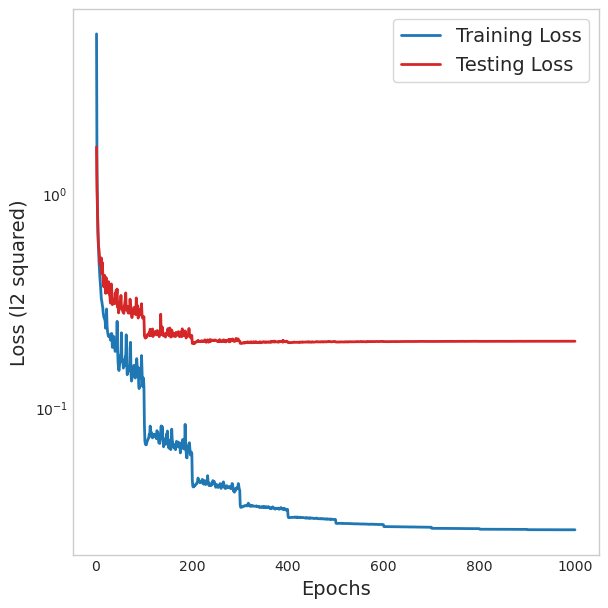

In [9]:
## Plotting the loss history

plot_loss( model.train_loss_log[:, 0], \
           model.test_loss_log[:, 0], \
           fs = 14, lw = 2, \
           savefile = results_dir+'loss_his.png', \
           figsize = [6,6])

## Test and plot the output of network

In [10]:
# load the model
model = torch.load(model_save_file, weights_only=False)

sfname = model_save_file.split(os.path.sep)
print('-'*50)
print('Model loaded from: {}'.format(sfname[-2] + '/' + sfname[-1]))
print('\n' + '-'*50)
print('Model metadata:', model.metadata.keys())
print('\n' + '-'*50)
print('Model:', model)

--------------------------------------------------
Model loaded from: PCANet/model.pkl

--------------------------------------------------
Model metadata: dict_keys(['data', 'num_train', 'num_test', 'num_inp_fn_points', 'num_out_fn_points', 'num_Y_components', 'out_coordinate_dimension', 'num_inp_red_dim', 'num_out_red_dim', 'num_layers', 'num_neurons', 'epochs', 'batch_size', 'lr'])

--------------------------------------------------
Model: PCANet(
  (net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=100, out_features=250, bias=True)
      (1-2): 2 x Linear(in_features=250, out_features=250, bias=True)
      (3): Linear(in_features=250, out_features=100, bias=True)
    )
  )
)


In [11]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data['X_train']).detach().cpu().numpy()
print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))
error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)
print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 100), test_pred shape: (1000, 100)
Num tests:  1000, Mean Loss (rel l2): 1.060e-01, Std Loss (rel l2): 3.565e-02


In [12]:
def apply_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids] = bc_value
    return u

i_plot =   801, error (rel l2): 7.305e-03
i_plot =   311, error (rel l2): 9.159e-03
i_plot =    85, error (rel l2): 7.269e-03
i_plot =   435, error (rel l2): 7.810e-03


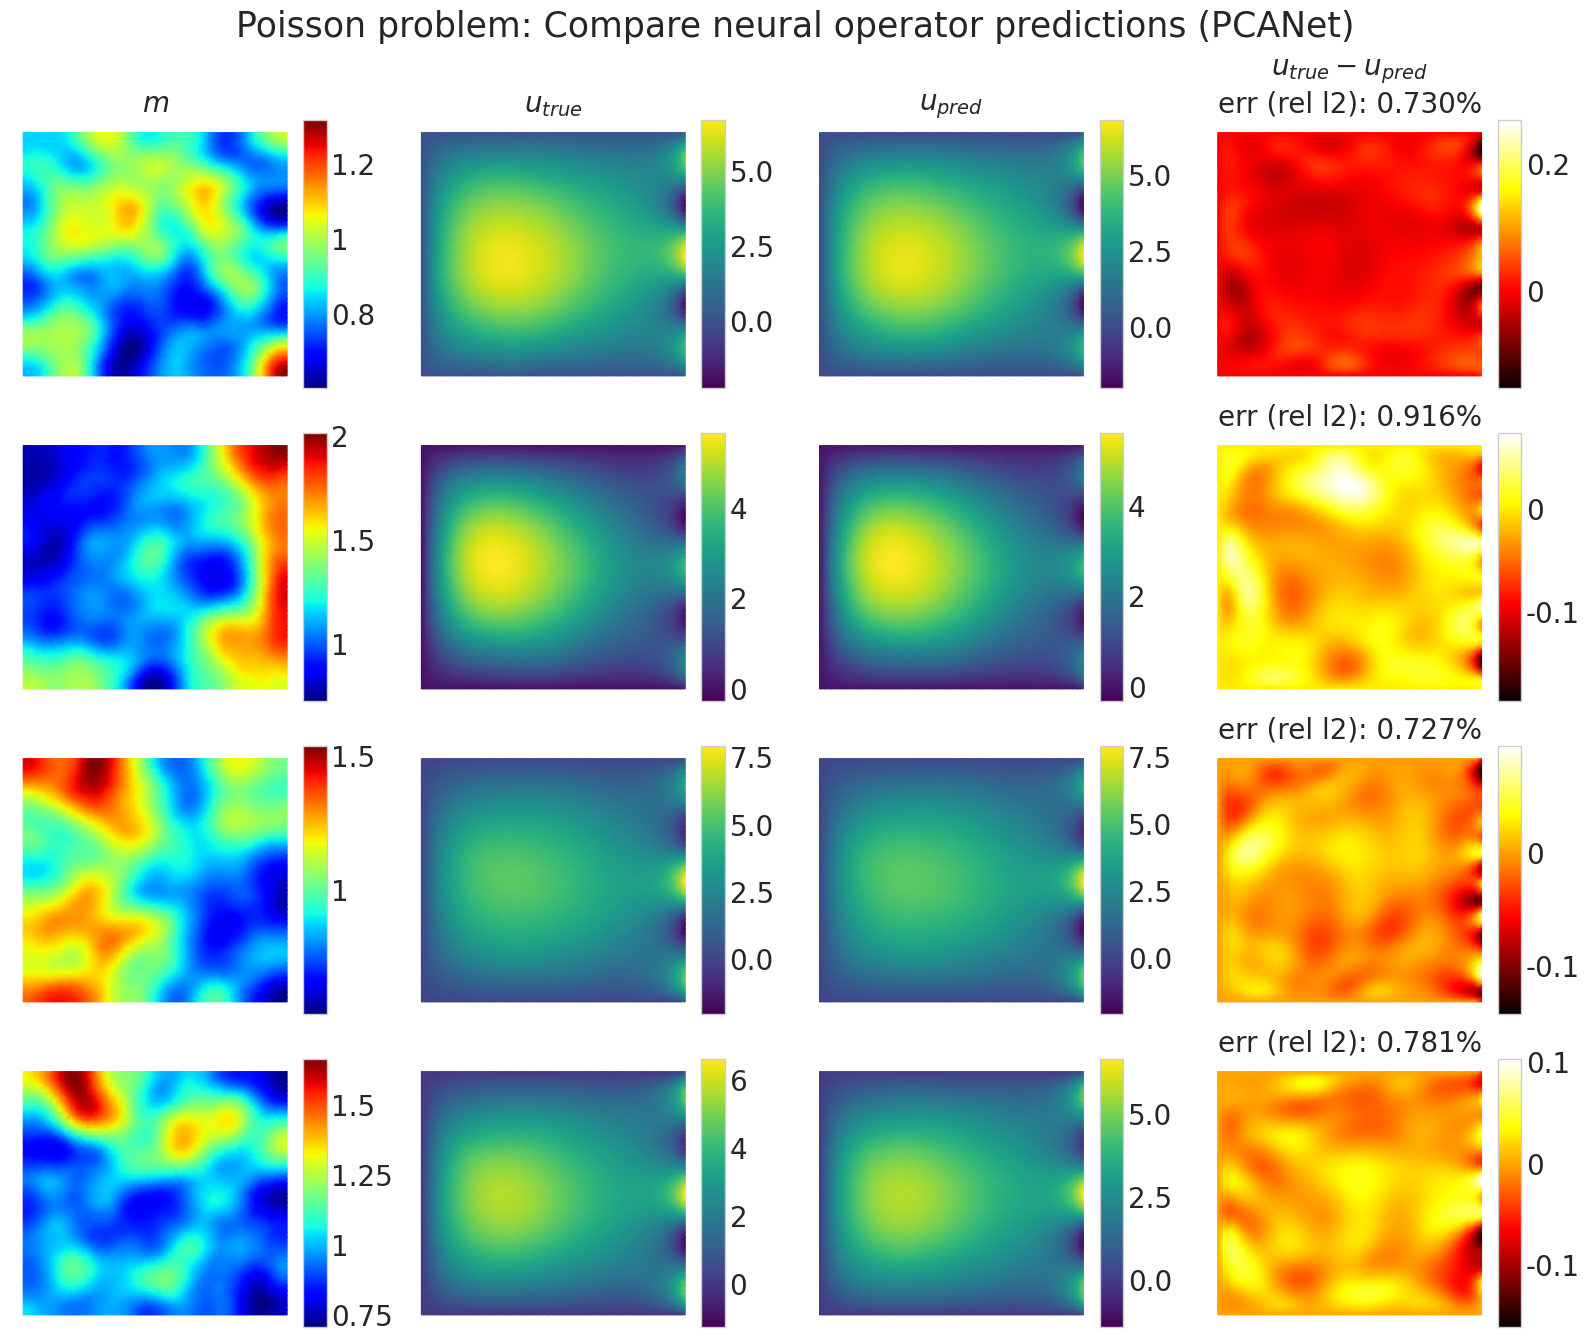

In [13]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

nodes = data.X_trunk 

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
    if apply_dirichlet_bc_flag:
        i_pred = apply_dirichlet_bc(i_pred, 0.0, data.u_mesh_dirichlet_boundary_nodes)
        # verify for i_truth
        if np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max() > 1.0e-9:
            print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max()))
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot(axs[i,j], uvec[j], nodes, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()

## Uncertainty Quantification Sampling

## HMC

In [7]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Keep a copy of the full model state for reconstruction
base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
all_params = list(model.parameters())

num_hmc_samples_data = 1000 
hmc_indices = np.random.choice(num_train, num_hmc_samples_data, replace=False)
x_hmc = train_data['X_train'][hmc_indices]
y_hmc = train_data['Y_train'][hmc_indices]
print(f"Using {num_hmc_samples_data} TRAINING samples for HMC")

model, flat0, prior_std = uq.freezelayer(model, device)
noise_std = 0.2
log_prob = uq.make_log_prob_fn(model, x_hmc, y_hmc, noise_std=noise_std, prior_std=prior_std)

# Adaptive hmc settings
hmc_num_samples = 5000
hmc_burn_in = 4900     
hmc_initial_step_size = 1e-4 # Start larger now that surface is smoother
hmc_leapfrog_steps = 20

hmc_samples = uq.hmc_nuts(
    log_prob, 
    flat0.requires_grad_(True), 
    initial_step_size=hmc_initial_step_size, 
    leapfrog_steps=hmc_leapfrog_steps, 
    num_samples=hmc_num_samples, 
    burn_in=hmc_burn_in
)
# Reconstruct full-parameter vectors so downstream code can load complete models
hmc_samples_full = torch.stack([uq.build_full_vector(model, base_state, all_params, s.detach()) for s in hmc_samples])
torch.save(hmc_samples_full, model_save_path + 'hmc_samples.pt')

Using 1000 TRAINING samples for HMC
Trainable params: 25100
Initial parameter vector shape (trainable only): torch.Size([25100])
Initial last-layer param std (scalar): 6.934e-02
Starting HMC with hamiltorch...
  Samples: 5000 + Burn-in: 4900
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec


/root/miniconda3/envs/neuralop/lib/python3.12/site-packages/hamiltorch/samplers.py:626: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(-h_new + h_old)


Final Adapted Step Size:  9.144392242887989e-05# | 4898/5000 | 40.25       
0d:00:02:04 | 0d:00:00:00 | #################### | 5000/5000 | 40.17       
Acceptance Rate 0.80


## SGLD

In [49]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Keep a copy of the full model state for reconstruction
base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
all_params = list(model.parameters())

# Use training data for posterior sampling
x_sgld = train_data['X_train']
y_sgld = train_data['Y_train']

# SGLD Sampling Parameters
num_samples = 10000      # Number of posterior samples to collect
burn_in = 2000          # Burn-in iterations
step_size = 1e-7       # Initial step size for SGLD (Adjusted for Last Layer)
step_decay = 0.9995    # Step size decay per iteration
min_step_size = 1e-9   # Minimum step size
sgld_batch_size = 100  # Mini-batch size
slices = 100           # Thinning factor to reduce autocorrelation in samples

model, flat0, prior_std = uq.freezelayer(model, device)
noise_std = 0.2

# Mini-batch log probability
log_prob_fn = uq.make_minibatch_log_prob_fn(
    model, x_sgld, y_sgld,
    batch_size=sgld_batch_size,
    prior_std=prior_std,
    noise_std=noise_std,
)

print("Running SGLD sampling...")
sgld_samples, final_step_size = uq.sgld(
    log_prob_fn,
    flat0,
    step_size=step_size,
    num_samples=num_samples,
    burn_in=burn_in,
    step_decay=step_decay,
    min_step_size=min_step_size,
)
sgld_samples = sgld_samples[::slices]  # Thinning
print(f"SGLD completed. Final step size: {final_step_size:.2e}")
print(f"Number of samples collected: {len(sgld_samples)}")
sgld_samples_full = torch.stack([uq.build_full_vector(model, base_state, all_params,s.detach()) for s in sgld_samples])

torch.save(sgld_samples_full, model_save_path + 'sgld_samples.pt')

Trainable params: 25100
Initial parameter vector shape (trainable only): torch.Size([25100])
Initial last-layer param std (scalar): 6.934e-02
Running SGLD sampling...
Starting SGLD sampling...
  Burn-in: 2000, Samples: 10000
  Initial step size: 1.00e-07
Iter  100/12000: step_size = 9.51e-08, phase = burn-in
Iter  200/12000: step_size = 9.05e-08, phase = burn-in
Iter  300/12000: step_size = 8.61e-08, phase = burn-in
Iter  400/12000: step_size = 8.19e-08, phase = burn-in
Iter  500/12000: step_size = 7.79e-08, phase = burn-in
Iter  600/12000: step_size = 7.41e-08, phase = burn-in
Iter  700/12000: step_size = 7.05e-08, phase = burn-in
Iter  800/12000: step_size = 6.70e-08, phase = burn-in
Iter  900/12000: step_size = 6.38e-08, phase = burn-in
Iter 1000/12000: step_size = 6.06e-08, phase = burn-in
Iter 1100/12000: step_size = 5.77e-08, phase = burn-in
Iter 1200/12000: step_size = 5.49e-08, phase = burn-in
Iter 1300/12000: step_size = 5.22e-08, phase = burn-in
Iter 1400/12000: step_size = 4

## Monte-Carlo Dropout

In [15]:
# It suffices to sample when evaluating.

## Laplace Approximation

In [10]:
# Laplace Approximation (sample last layer only, save full model vectors)
model = torch.load(model_save_file, weights_only=False)
model.to(device)
base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
all_params = list(model.parameters())

noise_std = 0.2
model, _, prior_std = uq.freezelayer(model, device)
# Check data size
x_la = train_data['X_train']
y_la = train_data['Y_train']
num_hessian_samples = min(500, x_la.shape[0])
idx = np.random.choice(x_la.shape[0], num_hessian_samples, replace=False)
x_hessian = x_la[idx]
y_hessian = y_la[idx]

trainable_params = [p for p in model.parameters() if p.requires_grad]
n_trainable = sum(p.numel() for p in trainable_params)

print(f"Computing diagonal Hessian approximation on {num_hessian_samples} samples...")
H_diag = uq.compute_diagonal_hessian(
    model, x_hessian, y_hessian,
    noise_std, prior_std, device, 
    batch_size=50, 
    sample_outputs_per_batch=100 
)

# Ensure alignment: Map only TRAINABLE parameters to vector
theta_map = parameters_to_vector(trainable_params).to(device)
H_flat = H_diag.flatten()

# Safety Check
if H_flat.numel() != theta_map.numel():
    raise ValueError(f"Shape Mismatch! Hessian: {H_flat.numel()}, Params: {theta_map.numel()}.")

# Posterior Variance Calculation
prior_precision = 1.0 / (prior_std ** 2)
posterior_precision = H_flat + prior_precision
# Add epsilon for numerical stability
posterior_var = 1.0 / (posterior_precision + 1e-8)
posterior_std_vec = torch.sqrt(posterior_var)

print(f"Hessian statistics: Mean={H_flat.mean().item():.2e}, Max={H_flat.max().item():.2e}")
print(f"Posterior sigma:    Mean={posterior_std_vec.mean().item():.2e}, Max={posterior_std_vec.max().item():.2e}")

# Sampling
num_la_samples = 50
print(f"Sampling {num_la_samples} vectors from Laplace posterior...")

la_samples = []
for i in range(num_la_samples):
    epsilon = torch.randn_like(theta_map)
    theta_sample = theta_map + posterior_std_vec * epsilon
    la_samples.append(theta_sample)

# Stack and Save
la_samples_full = torch.stack([uq.build_full_vector(model, base_state, all_params, s) for s in la_samples])
print(f"Generated {len(la_samples_full)} samples.")

torch.save(la_samples_full, model_save_path + 'la_samples.pt')

Trainable params: 25100
Initial parameter vector shape (trainable only): torch.Size([25100])
Initial last-layer param std (scalar): 6.934e-02
Computing diagonal Hessian approximation on 500 samples...
  Processed 100/500 samples
  Processed 200/500 samples
  Processed 300/500 samples
  Processed 400/500 samples
  Processed 500/500 samples
Hessian statistics: Mean=1.04e+05, Max=1.52e+06
Posterior sigma:    Mean=1.85e-02, Max=4.90e-02
Sampling 50 vectors from Laplace posterior...
Generated 50 samples.


## Ensemble learning

In [11]:
models = []
model_num = 10
model_save_paths = [model_save_path + f'model_{i+1}.pkl' for i in range(model_num)]

In [15]:
for i in range(model_num):
    torch.manual_seed(1000*(i+1))
    model_save_files = model_save_paths[i]
    model_new = PCANet(num_layers, num_neurons, act_fn, \
               num_inp_red_dim, num_out_red_dim, \
               save_file = model_save_file)
    model_new = model.to(device)
    model_new.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)
    torch.save(model_new, model_save_files)
    models.append(model_new)

Using device: cuda
--------------------------------------------------
Starting training with 175850 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 1.471e-01, Test Loss (l2 squared): 3.103e-01, Time (sec): 0.436
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 9.359e-02, Test Loss (l2 squared): 2.359e-01, Time (sec): 0.382
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 4.716e-02, Test Loss (l2 squared): 1.983e-01, Time (sec): 0.246
--------------------------------------------------
--------------------------------------------------
Model parameters save

## Evaluation metrics

In [50]:
results_id = []
results_shifting = []
std_id = []
std_shifting = []

In [51]:
hmc_samples = torch.load(model_save_path + 'hmc_samples.pt').to(device)
std_hmc = []
results_hmc = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_hmc.append(std_i)
        results_hmc.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_hmc))
results_shifting.append(np.stack(results_hmc))
del hmc_samples

Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 8 epoch


In [52]:
sgld_samples = torch.load(model_save_path + 'sgld_samples.pt').to(device)
std_sgld = []
results_sgld = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i == -1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'sgld', sgld_samples=sgld_samples.clone())
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'sgld', sgld_samples=sgld_samples.clone())
        std_sgld.append(std_i)
        results_sgld.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_sgld))
results_shifting.append(np.stack(results_sgld))
del sgld_samples

Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 8 epoch


In [53]:
std_mcd = []
results_mcd = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    uq.inject_dropout(model, dropout_rate=0.05)
    torch.nn.Module.train(model)
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            torch.nn.Module.train(module)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'mcd')
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'mcd')
        std_mcd.append(std_i)
        results_mcd.append(result_i)
    print(f" Complete {i+1} epoch")
std_shifting.append(np.stack(std_mcd))
results_shifting.append(np.stack(results_mcd))

Evaluating uncertainty on 400 test samples...
 Complete 0 epoch
Evaluating uncertainty on 400 test samples...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
 Complete 7 epoch


In [54]:
la_samples = torch.load(model_save_path + 'la_samples.pt').to(device)
std_la = []
results_la = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'la', la_samples=la_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'la', la_samples=la_samples.clone()) # pyright: ignore[reportAttributeAccessIssue]
        std_la.append(std_i)
        results_la.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_la))
results_shifting.append(np.stack(results_la))
del la_samples

Evaluating uncertainty on 400 test samples...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
 Complete 8 epoch


In [55]:
std_de = []
results_de = []
for i in range(-1,7):
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, None, 'de', model_ensemble=model_save_paths)  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], None, 'de', model_ensemble=model_save_paths) # pyright: ignore[reportAttributeAccessIssue]
        std_de.append(std_i)
        results_de.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_de))
results_shifting.append(np.stack(results_de))

Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 8 epoch


In [56]:
# Save UQ results
results_id = np.array(results_id) # method*metric
results_shifting = np.array(results_shifting) # method*datatype*metric
std_id = np.array(std_id) # method*sample
std_shifting = np.array(std_shifting) # method*datatype*sample
np.savez(model_save_path + 'uq_results_pcanet.npz', results_id=results_id, results_shifting=results_shifting, std_id=std_id, std_shifting=std_shifting)

## Assess evaluation metrics

In [57]:
# load data if needed
results_id, results_shifting, std_id, std_shifting = np.load(model_save_path + 'uq_results_pcanet.npz').values()

### ID data performance

In [58]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approx', 'Deep Ensemble']
uq_eval.comparison_uq(results_id, method)


Metric                             HMC         SGLD   MC Dropout laplace Approx
-------------------------------------------------------------------------------------
RMSE                            0.4109       0.7079       0.4484     0.3881
Coverage 1σ (%)                  51.14        27.97        93.75      59.01
Coverage 2σ (%)                  79.02        52.55        99.92      84.25
Coverage 3σ (%)                  90.69        71.30       100.00      93.75
MPIW                            0.8170       0.9623       4.5018     0.9265
NLL                             1.3442       3.8764       0.6241     0.8307


### Shifting data performance

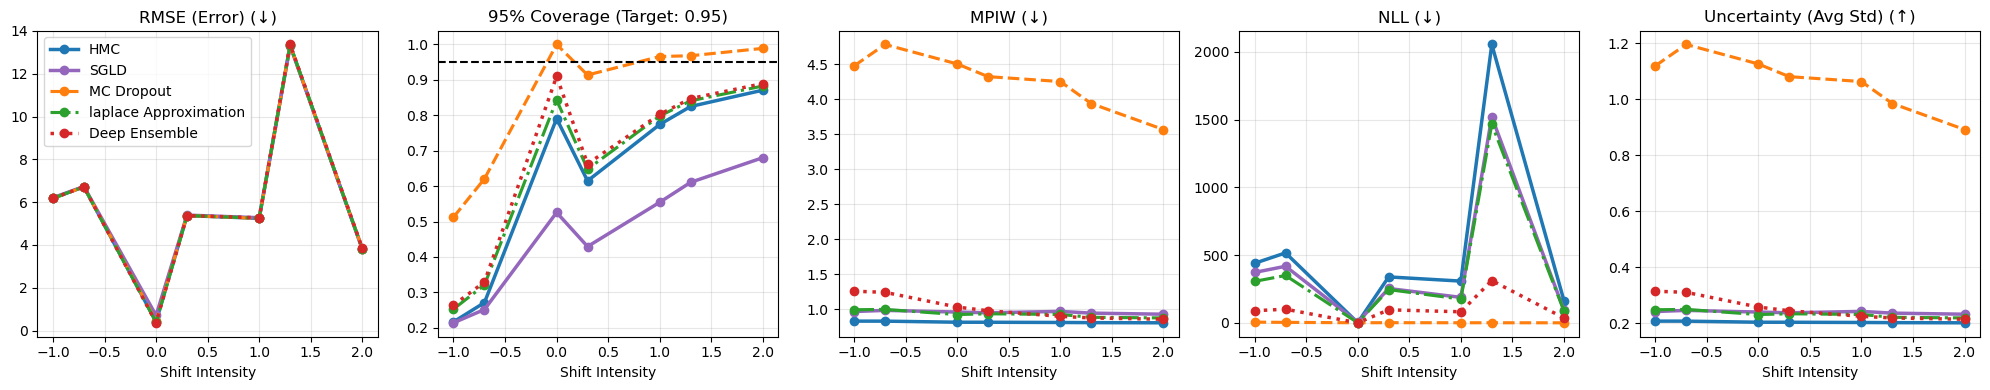

In [59]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
levels = [-1, -0.7, 0, 0.3, 1, 1.3, 2]
results_shifting_copy = results_shifting.copy()
results_shifting_copy[:,0,:] = results_id
results_shifting_copy[:,[2,0,1],:] = results_shifting_copy[:,[0,1,2],:]
uq_eval.run_regression_shift(method, levels, results_shifting_copy)

### Robustness check

In [60]:
uq_eval.comparison_uq(results_shifting[:,0,:], method)


Metric                             HMC         SGLD   MC Dropout laplace Approximation
-------------------------------------------------------------------------------------
RMSE                            7.9618       7.9508       7.9427     7.9623
Coverage 1σ (%)                  31.26        18.43        61.42      36.25
Coverage 2σ (%)                  51.00        35.72        87.13      55.75
Coverage 3σ (%)                  62.23        50.47        95.42      65.67
MPIW                            0.8200       0.9621       4.5730     0.9446
NLL                           750.4717     619.3630       1.5188   544.2379


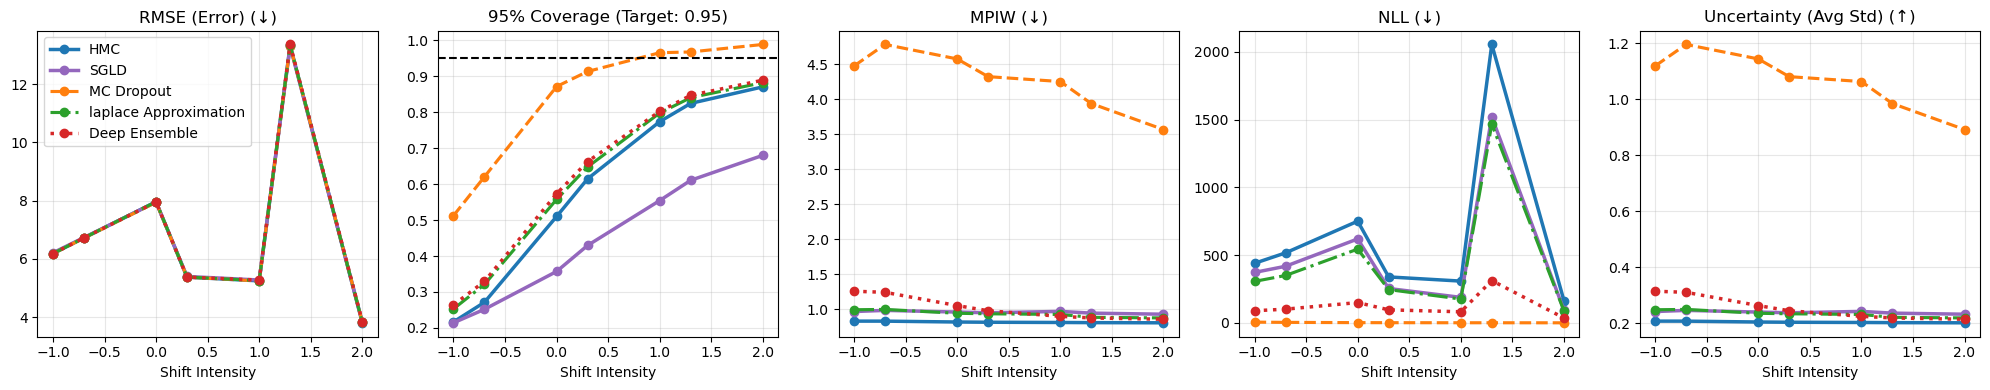

In [61]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
levels = [-1, -0.7, 0, 0.3, 1, 1.3, 2]
results_shifting_copy = results_shifting.copy()
results_shifting_copy[:,[2,0,1],:] = results_shifting_copy[:,[0,1,2],:]
uq_eval.run_regression_shift(method, levels, results_shifting_copy)

## OOD data detection

Method: HMC, Data: 0.005 -> AUROC: 0.6162
Method: HMC, Data: 0.0005 -> AUROC: 0.8780
Method: HMC, Data: 0.001 -> AUROC: 0.8676
Method: HMC, Data: 0.01 -> AUROC: 0.3591
Method: HMC, Data: 0.05 -> AUROC: 0.2403
Method: HMC, Data: 0.1 -> AUROC: 0.2250
Method: HMC, Data: 0.5 -> AUROC: 0.1589
Method: SGLD, Data: 0.005 -> AUROC: 0.4986
Method: SGLD, Data: 0.0005 -> AUROC: 0.5266
Method: SGLD, Data: 0.001 -> AUROC: 0.6031
Method: SGLD, Data: 0.01 -> AUROC: 0.3513
Method: SGLD, Data: 0.05 -> AUROC: 0.3213
Method: SGLD, Data: 0.1 -> AUROC: 0.3094
Method: SGLD, Data: 0.5 -> AUROC: 0.2637
Method: MC Dropout, Data: 0.005 -> AUROC: 0.5185
Method: MC Dropout, Data: 0.0005 -> AUROC: 0.4882
Method: MC Dropout, Data: 0.001 -> AUROC: 0.5923
Method: MC Dropout, Data: 0.01 -> AUROC: 0.3744
Method: MC Dropout, Data: 0.05 -> AUROC: 0.3234
Method: MC Dropout, Data: 0.1 -> AUROC: 0.3185
Method: MC Dropout, Data: 0.5 -> AUROC: 0.2646
Method: laplace Approximation, Data: 0.005 -> AUROC: 0.5789
Method: laplace A

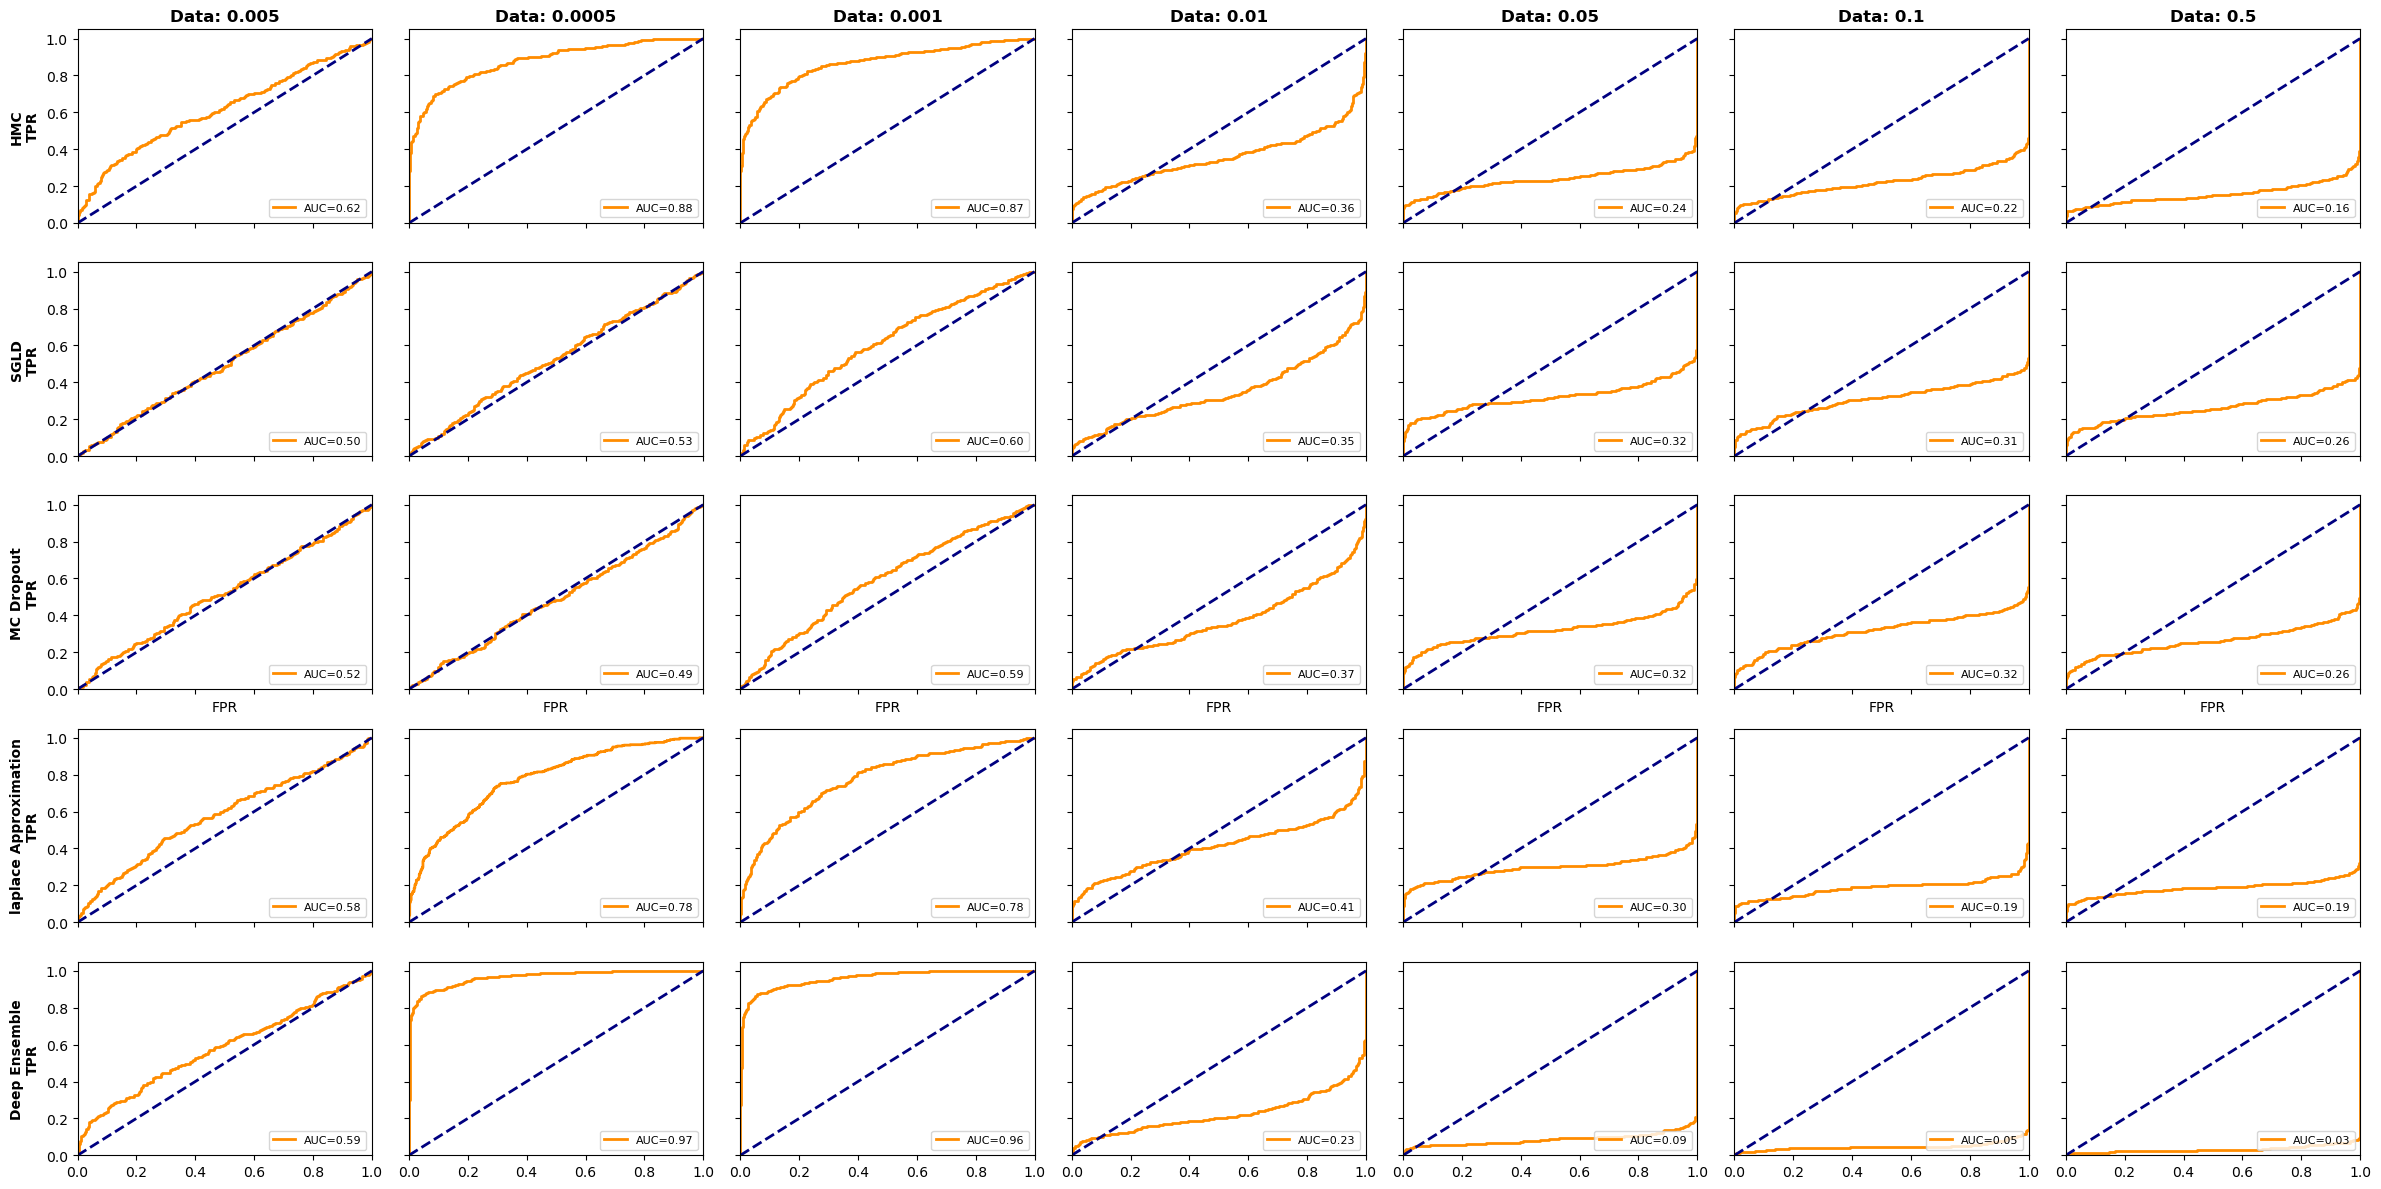

In [62]:
uq_methods_list = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
datatypes = [0.005, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(24, 12), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes):
        ax = axes[i, j]
        ood = np.concatenate((std_id[i], std_shifting[i][j]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_id[i].shape[0]), np.ones(std_shifting[i][j].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

Method: HMC, Data: 0.0005 -> AUROC: 0.7915
Method: HMC, Data: 0.001 -> AUROC: 0.7813
Method: HMC, Data: 0.01 -> AUROC: 0.3001
Method: HMC, Data: 0.05 -> AUROC: 0.2092
Method: HMC, Data: 0.1 -> AUROC: 0.1919
Method: HMC, Data: 0.5 -> AUROC: 0.1366
Method: SGLD, Data: 0.0005 -> AUROC: 0.5272
Method: SGLD, Data: 0.001 -> AUROC: 0.6019
Method: SGLD, Data: 0.01 -> AUROC: 0.3552
Method: SGLD, Data: 0.05 -> AUROC: 0.3228
Method: SGLD, Data: 0.1 -> AUROC: 0.3100
Method: SGLD, Data: 0.5 -> AUROC: 0.2650
Method: MC Dropout, Data: 0.0005 -> AUROC: 0.4701
Method: MC Dropout, Data: 0.001 -> AUROC: 0.5684
Method: MC Dropout, Data: 0.01 -> AUROC: 0.3651
Method: MC Dropout, Data: 0.05 -> AUROC: 0.3189
Method: MC Dropout, Data: 0.1 -> AUROC: 0.3108
Method: MC Dropout, Data: 0.5 -> AUROC: 0.2600
Method: laplace Approximation, Data: 0.0005 -> AUROC: 0.6944
Method: laplace Approximation, Data: 0.001 -> AUROC: 0.6998
Method: laplace Approximation, Data: 0.01 -> AUROC: 0.3723
Method: laplace Approximation, 

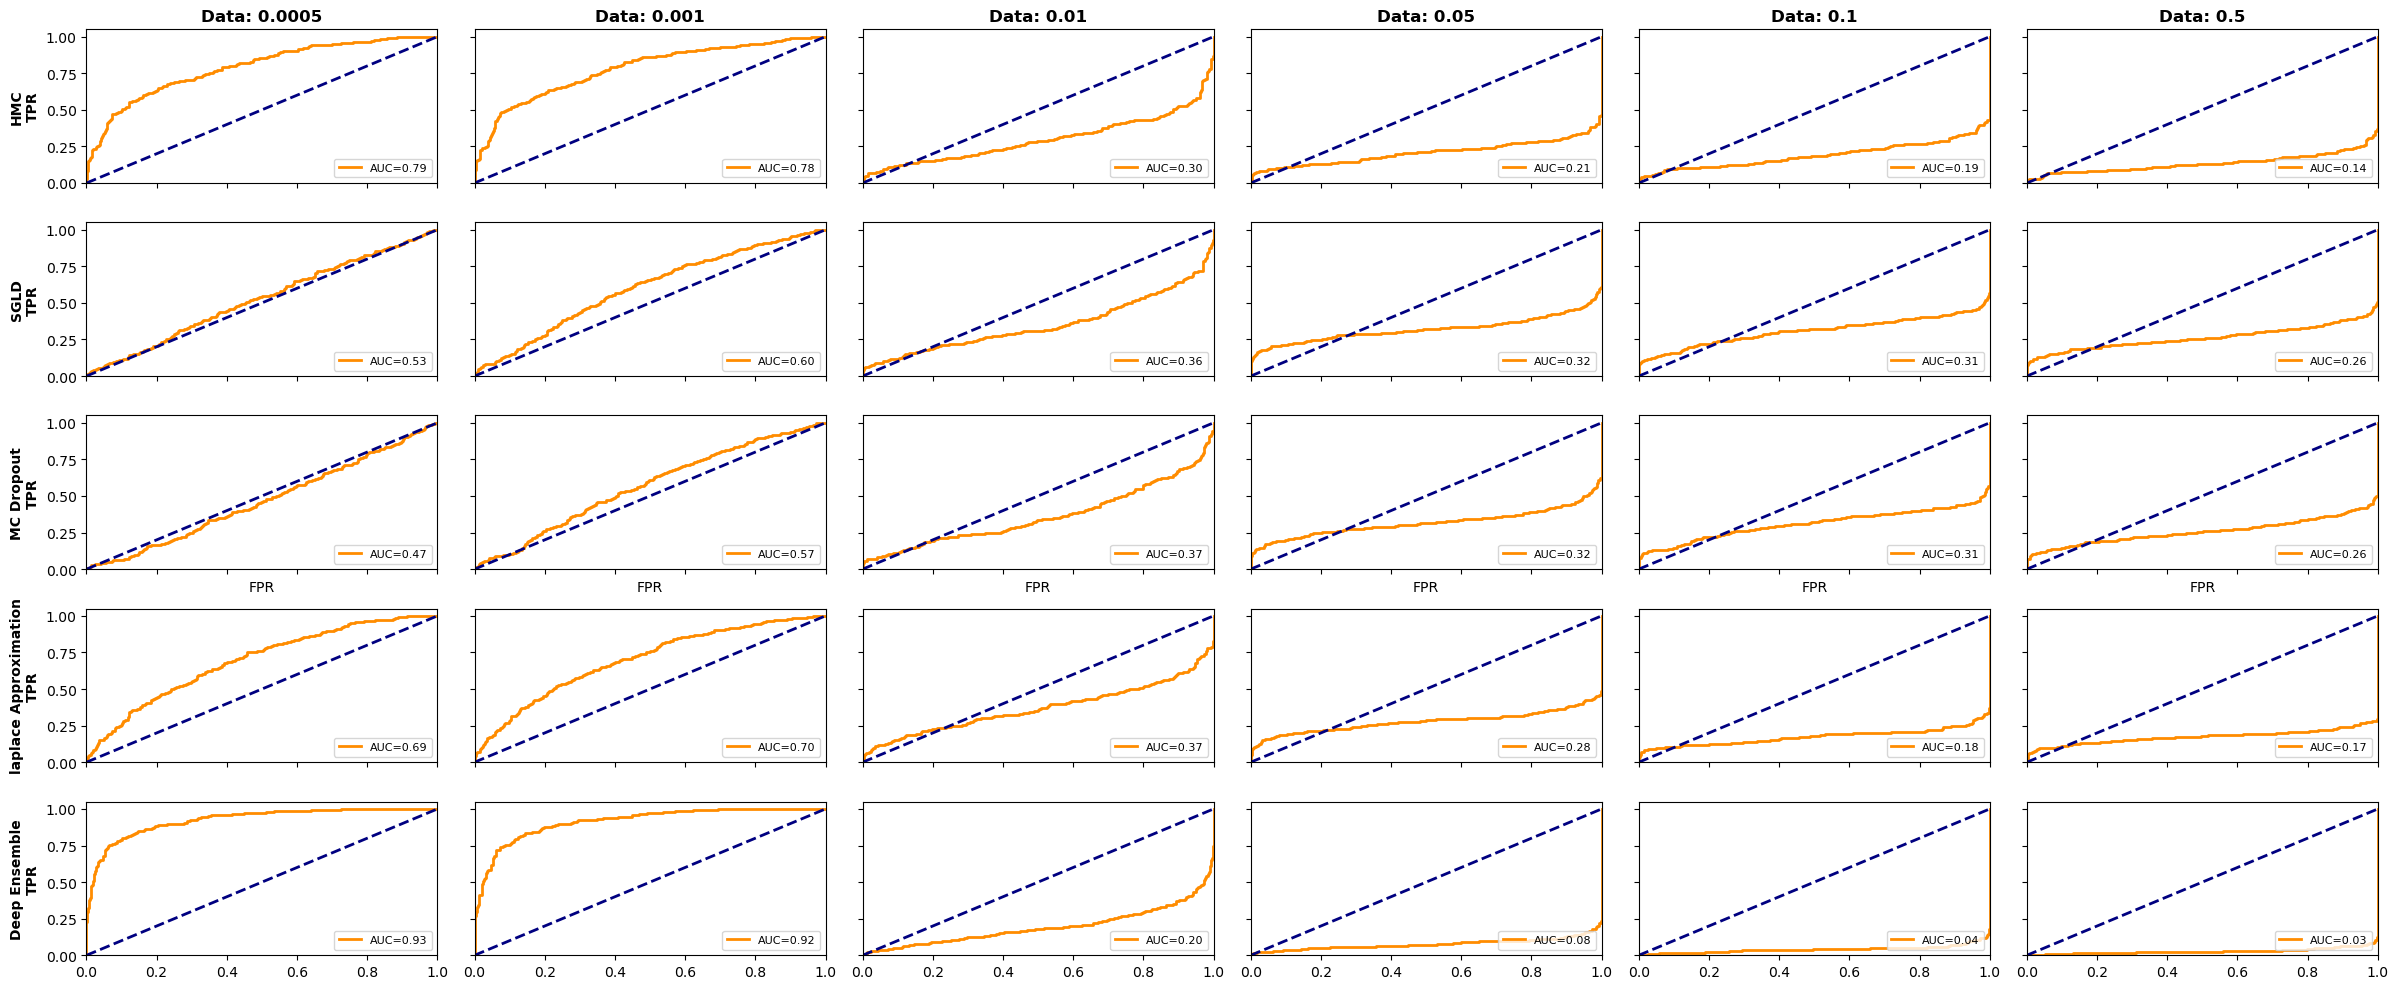

In [63]:
# If robustness check fails, compare between new samples.
uq_methods_list = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
datatypes = [0.005, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(24, 10), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes[1:]): # Skip index 0 (no-ood) to match ncols=6
        ax = axes[i, j]
        ood = np.concatenate((std_shifting[i][0], std_shifting[i][j+1]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_shifting[i][0].shape[0]), np.ones(std_shifting[i][j+1].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Conformal Prediction

In [64]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
alpha = 0.1  # Target error rate (90% coverage)
n_cal = 500  # Number of samples for calibration

# Split remaining test data into calibration and final test
indices = np.arange(num_test) # Use num_test (1000) instead of num_test_shift (400)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:]

# Get predictions for calibration set
x_branch_cal = test_data['X_train'][cal_idx]
y_cal = test_data['Y_train'][cal_idx]

with torch.no_grad():
    x_b = torch.from_numpy(x_branch_cal).float().to(device)
    y_cal_pred = model.predict(x_b).cpu().numpy()

# Calculate non-conformity scores (Absolute Residuals)
# For vector outputs, we use point-wise absolute error
scores = np.abs(y_cal - y_cal_pred)

# Compute the (1-alpha) quantile of the scores
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(scores, q_level, axis=0) # Point-wise quantile

print(f"Calibration complete using {n_cal} samples.")
print(f"Quantile (qhat) mean value: {qhat.mean():.4f}")

Calibration complete using 500 samples.
Quantile (qhat) mean value: 0.5635


Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 59.6%
ID Coverage: 90.7%
OOD Coverage: 20.8%
Average Prediction Interval Width: 1.1270
AUROC of 0.0005 for OOD detection: 1.0
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 62.0%
ID Coverage: 90.7%
OOD Coverage: 26.2%
Average Prediction Interval Width: 1.1270
AUROC of 0.001 for OOD detection: 1.0
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 80.3%
ID Coverage: 90.7%
OOD Coverage: 67.3%
Average Prediction Interval Width: 1.1270
AUROC of 0.01 for OOD detection: 0.9974625
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 87.9%
ID Coverage: 90.7%
OOD Coverage: 84.3%
Average Prediction Interval Width: 1.1270
AUROC of 0.05 for OOD detection: 0.8177525
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 89.9%
ID Coverage: 90.7%
OOD Coverage: 88.9%
Average Prediction Interval Width: 1.1270
AUROC of 0.1 for OOD detection: 

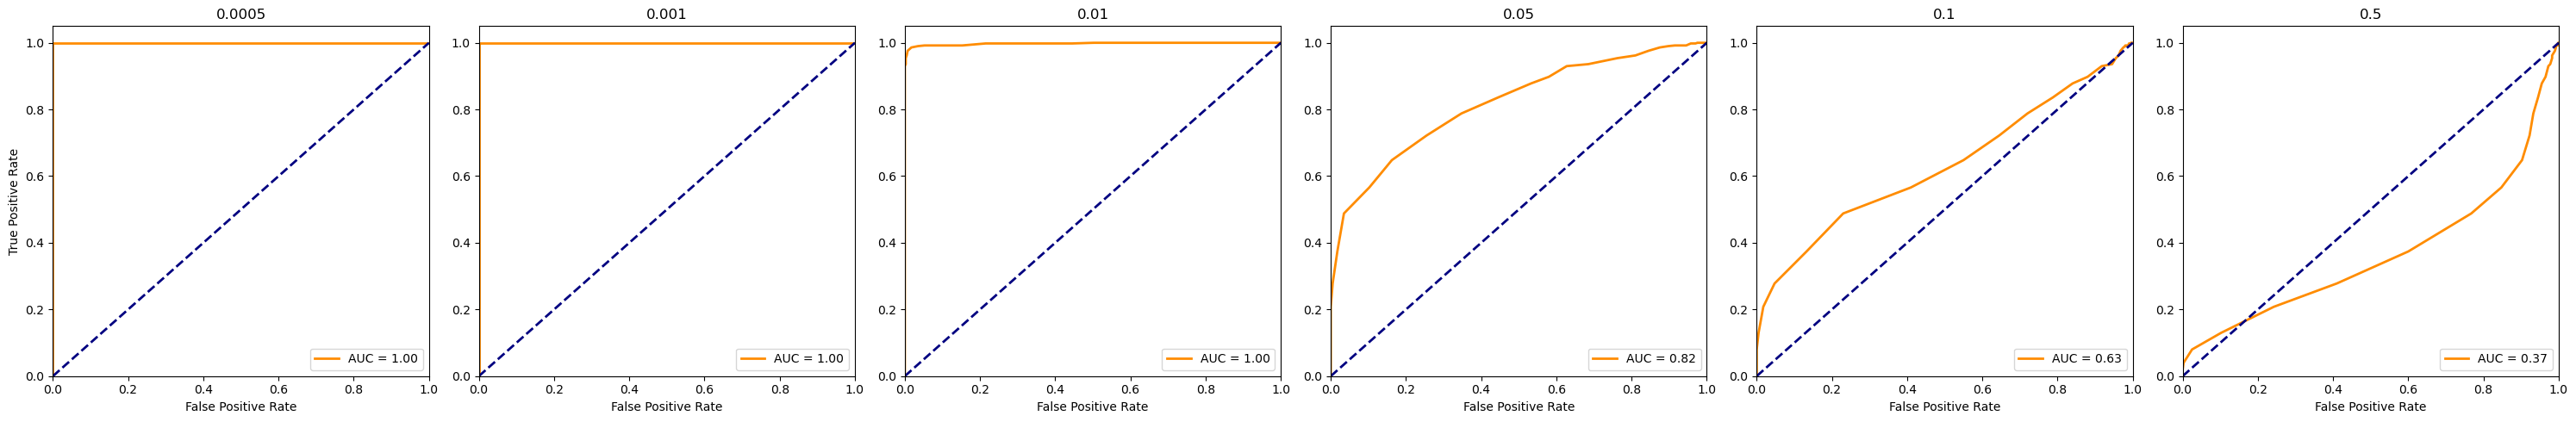

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30, 5)) 
for i, datatype in enumerate(datatypes[1:]): # Skip index 0 (no-ood) to match ncols=6
    
    ax = axes[i]
    # Evaluate on the remaining test set
    x_branch_final = np.concatenate((test_data['X_train'][test_idx], data_shifting_data[i+1]['X_train']), axis=0) 
    y_test_final = np.concatenate((test_data['Y_train'][test_idx], data_shifting_data[i+1]['Y_train']), axis=0) 

    with torch.no_grad():
        x_b_final = torch.from_numpy(x_branch_final).float().to(device)
        y_test_pred = model.predict(x_b_final).cpu().numpy()

    # Prediction Intervals: [pred - qhat, pred + qhat]
    lower_bound = y_test_pred - qhat
    upper_bound = y_test_pred + qhat

    # Calculate empirical coverage
    cover = ((y_test_final >= lower_bound) & (y_test_final <= upper_bound)).mean(axis=1)
    coverage = cover.mean()
    cover_id = cover[:len(test_idx)]
    cover_ood = cover[len(test_idx):]
    cover_id_mean = cover_id.mean() 
    cover_ood_mean = cover_ood.mean()

    print(f"Results for alpha = {alpha} (Target Coverage: {1-alpha:.1%})")
    print(f"Empirical Test Coverage: {coverage:.1%}")
    print(f"ID Coverage: {cover_id_mean:.1%}")
    print(f"OOD Coverage: {cover_ood_mean:.1%}")
    print(f"Average Prediction Interval Width: {(upper_bound - lower_bound).mean():.4f}")


    oods = np.concatenate((np.ones(len(test_idx)), np.zeros(len(x_branch_final)-len(test_idx))), axis=0)

    auroc = roc_auc_score(oods, cover)
    fpr, tpr, _ = roc_curve(oods, cover)
    
    print(f"AUROC of {datatype} for OOD detection: {auroc}")

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')

    if i == 0:
        ax.set_ylabel('True Positive Rate')
    
    ax.set_title(f'{datatype}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [66]:
# If robustness check fails, recalibrate using new samples.

model = torch.load(model_save_file, weights_only=False)
model.to(device)
alpha = 0.1  # Target error rate (90% coverage)
n_cal = 100  # Number of samples for calibration

# Split remaining test data into calibration and final test
num_samples_shift = data_shifting_data[0]['X_train'].shape[0] # Get actual number of samples (400)
indices = np.arange(num_samples_shift)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:]

# Get predictions for calibration set
x_branch_cal = data_shifting_data[0]['X_train'][cal_idx]
y_cal = data_shifting_data[0]['Y_train'][cal_idx]

if isinstance(y_cal, torch.Tensor):
    y_cal = y_cal.cpu().numpy()
y_cal = y_cal.reshape(y_cal.shape[0], -1)

with torch.no_grad():
    if isinstance(x_branch_cal, torch.Tensor):
        x_b = x_branch_cal.float().to(device)
    else:
        x_b = torch.from_numpy(x_branch_cal).float().to(device)
    y_cal_pred = model.predict(x_b).cpu().numpy()
    y_cal_pred = y_cal_pred.reshape(y_cal_pred.shape[0], -1)

# Calculate non-conformity scores (Absolute Residuals)
scores = np.abs(y_cal - y_cal_pred)

# Compute the (1-alpha) quantile of the scores
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(scores, q_level, axis=0) # Point-wise quantile

print(f"Calibration complete using {n_cal} samples.")
print(f"Quantile (qhat) mean value: {qhat.mean():.4f}")

Calibration complete using 100 samples.
Quantile (qhat) mean value: 4.2903


Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 67.3%
ID Coverage: 90.5%
OOD Coverage: 49.8%
Average Prediction Interval Width: 8.5807
AUROC of 0.0005 for OOD detection: 1.0
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 71.7%
ID Coverage: 90.5%
OOD Coverage: 57.6%
Average Prediction Interval Width: 8.5807
AUROC of 0.001 for OOD detection: 0.9999583333333333
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 94.2%
ID Coverage: 90.5%
OOD Coverage: 96.9%
Average Prediction Interval Width: 8.5807
AUROC of 0.01 for OOD detection: 0.11260416666666666
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 95.6%
ID Coverage: 90.5%
OOD Coverage: 99.4%
Average Prediction Interval Width: 8.5807
AUROC of 0.05 for OOD detection: 0.012687499999999973
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 95.6%
ID Coverage: 90.5%
OOD Coverage: 99.5%
Average Prediction Interval Width: 8.5

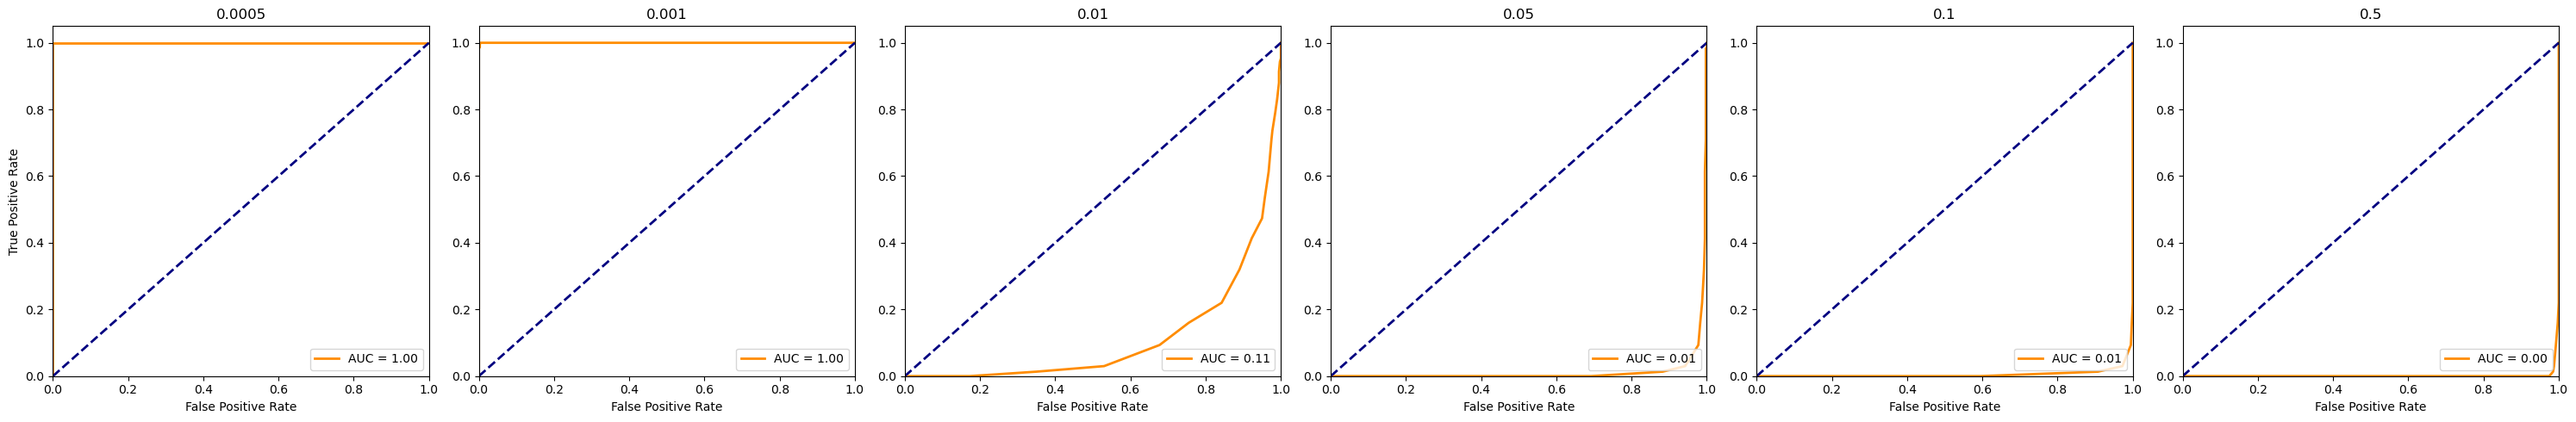

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30, 5)) 
for i, datatype in enumerate(datatypes[1:]): # Skip index 0 (no-ood) to match ncols=6
    
    ax = axes[i]
    # Evaluate on the remaining test set
    x_branch_final = np.concatenate((data_shifting_data[0]['X_train'][test_idx], data_shifting_data[i+1]['X_train']), axis=0) 
    y_test_final = np.concatenate((data_shifting_data[0]['Y_train'][test_idx], data_shifting_data[i+1]['Y_train']), axis=0) 
    y_test_final = y_test_final.reshape(y_test_final.shape[0], -1)

    with torch.no_grad():
        x_b_final = torch.from_numpy(x_branch_final).float().to(device)
        y_test_pred = model.predict(x_b_final).cpu().numpy()
        y_test_pred = y_test_pred.reshape(y_test_pred.shape[0], -1)

    # Prediction Intervals: [pred - qhat, pred + qhat]
    lower_bound = y_test_pred - qhat
    upper_bound = y_test_pred + qhat

    # Calculate empirical coverage
    cover = ((y_test_final >= lower_bound) & (y_test_final <= upper_bound)).mean(axis=1)
    coverage = cover.mean()
    cover_id = cover[:len(test_idx)]
    cover_ood = cover[len(test_idx):]
    cover_id_mean = cover_id.mean() 
    cover_ood_mean = cover_ood.mean()

    print(f"Results for alpha = {alpha} (Target Coverage: {1-alpha:.1%})")
    print(f"Empirical Test Coverage: {coverage:.1%}")
    print(f"ID Coverage: {cover_id_mean:.1%}")
    print(f"OOD Coverage: {cover_ood_mean:.1%}")
    print(f"Average Prediction Interval Width: {(upper_bound - lower_bound).mean():.4f}")


    oods = np.concatenate((np.ones(len(test_idx)), np.zeros(len(x_branch_final)-len(test_idx))), axis=0)

    auroc = roc_auc_score(oods, cover)
    fpr, tpr, _ = roc_curve(oods, cover)
    
    print(f"AUROC of {datatype} for OOD detection: {auroc}")

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')

    if i == 0:
        ax.set_ylabel('True Positive Rate')
    
    ax.set_title(f'{datatype}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()